In [ ]:
# This notebook reads in simulated Fizeau PSFs and checks the gradients in the 
# PTF, so as to try to get a better intuition for what the gradient is saying 
# about needed tip-tilt offsets

# Created 2019 Feb 13 by E.S. (by branching off of (testing_making_set_masks.ipynb)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle, SkyCoord
from astropy.nddata.utils import extract_array
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion, PolygonPixelRegion
from pyregion import read_region_as_imagecoord, get_mask
import csv
import time
import pickle 
% matplotlib inline

In [29]:
from lmircam_tools import *
from lmircam_tools import overlap_psfs

In [30]:
# for starters, read in some real data and FFT the Fizeau/Airy PSFs

In [31]:
'''
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+
        '180507_fizeau_altair/03_ramp_removed_pca_background_subted/')
'''

"\nstem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+\n        '180507_fizeau_altair/03_ramp_removed_pca_background_subted/')\n"

In [32]:
stem_pickle = ('/pickle_files/') # the PSFs are stored with other things in pickle files

In [5]:
# if I want to read in a test frame of a simulated PSF, retrieve the pickle file and save the relevant
# array as a FITS file

# loop over tilt increments
for i in range(0,6):
    f = 2*i
    print(f)

    dict_file = open('./pickle_files/chrom_mono_avgwavel_5000_opd_00000_tip_0000'+\
                 '_tilt_'+str("{:0>4d}".format(f))+'_transl_000_PS_10.pkl', 'r')
    dict_pkld = pickle.load(dict_file)

    hdu = fits.PrimaryHDU(dict_pkld['PSF_image'])
    hdul = fits.HDUList([hdu])
    hdul.writeto('./pickle_files/fits_equivalents/chrom_mono_avgwavel_5000_opd_00000_tip_0000'+\
                 '_tilt_'+str("{:0>4d}".format(f))+'_transl_000_PS_10.fits', overwrite=True)


0
2
4
6
8
10


In [33]:
# (this for single images)

# loop over tilt increments
for i in range(0,1):
    f = 2*i
    print(f)
    filename_str = './pickle_files/chrom_mono_avgwavel_5000_opd_00000_tip_0000_tilt_0500_transl_000_PS_10.pkl'    
    dict_file = open(filename_str, 'r')
    dict_pkld = pickle.load(dict_file)

    hdu = fits.PrimaryHDU(dict_pkld['PSF_image'])
    hdul = fits.HDUList([hdu])
    hdul.writeto('junk.fits', overwrite=True)


0


In [7]:
# if I want to make a fake test frame involving simple gradients, generate it here
# and save array as a FITS file

# For a plane ax+by+c=z

'''
a = 116
b = 1
c = 10

xcoords_1d = np.arange(0,2048)
ycoords_1d = np.copy(xcoords_1d)

xv, yv = np.meshgrid(xcoords_1d, ycoords_1d)
zv_right = a*xv + b*yv + c

zv_left = c*xv + a*yv + b


# test to make sure I'm making the image I think I'm making
x_test = 99
y_test = 999
print(a*x_test + b*y_test + c)
print(zv[999][99])

plt.imshow(zv)
plt.colorbar()
plt.show()

hdu = fits.PrimaryHDU(zv)
hdul = fits.HDUList([hdu])
hdul.writeto('slope_test_psf.fits', overwrite=True)
'''

"\na = 116\nb = 1\nc = 10\n\nxcoords_1d = np.arange(0,2048)\nycoords_1d = np.copy(xcoords_1d)\n\nxv, yv = np.meshgrid(xcoords_1d, ycoords_1d)\nzv_right = a*xv + b*yv + c\n\nzv_left = c*xv + a*yv + b\n\n\n# test to make sure I'm making the image I think I'm making\nx_test = 99\ny_test = 999\nprint(a*x_test + b*y_test + c)\nprint(zv[999][99])\n\nplt.imshow(zv)\nplt.colorbar()\nplt.show()\n\nhdu = fits.PrimaryHDU(zv)\nhdul = fits.HDUList([hdu])\nhdul.writeto('slope_test_psf.fits', overwrite=True)\n"

In [6]:
# set units of the observation

wavel_lambda = 5.0e-6 # filter central wavel (meters); n.b. Br-alpha is 4.051 um
D = 8.25 # diameter of one downstopped primary mirror (meters)
B_c2c = 14.4 # center-to-center separation (meters)
B_e2e = 22.65 # edge-to-edge separation (meters)
plateScale = 0.0107 # (asec/pixel)
global asecInRad # define global value
asecInRad = 206264.81 # (asec/rad)

In [7]:
# locations of Airy minima/maxima (units lambda/D)

max1 = 0
min1 = 1.220
max2 = 1.635
min2 = 2.233
max3 = 2.679
min3 = 3.238
max4 = 3.699

In [8]:
def findFFTloc(baseline,imageShapeAlong1Axis,wavel_lambda,plateScale,lOverD=1.):
    '''
    Returns the FFT pixel locations equivalent to a certain pixel distance on the science image 
    '''
    
    # baseline: distance in physical space in the pupil plane (m)
    # imageShapeAlong1Axis: length of one side of the input image (needs to be square)
    # wavel_lambda: wavelength of light (m)
    # plateScale: detector plate scale (asec/pix)
    # lOverD: option if we are interested in the circular Airy rings (values 1.22, etc.); otherwise, just leave as 1
    
    line_diam_pixOnScience = lOverD*(wavel_lambda*asecInRad)/(baseline*plateScale) # distance in pixels on science detector
    line_diam_freq = np.divide(1.,line_diam_pixOnScience) # the corresponding frequency

    # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    line_diam_pixOnFFT_L = 0.5*imageShapeAlong1Axis - np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) 
    line_diam_pixOnFFT_H = 0.5*imageShapeAlong1Axis + np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis))
    
    return line_diam_pixOnFFT_L, line_diam_pixOnFFT_H # the lower and higher values around freq of zero

In [9]:
def normalVector(sciImg):
    '''
    Fit a plane by finding the (normalized) normal vector to the best-fit plane
    
    INPUTS:
    sciImg: 2D image to fit a plane to
    
    OUTPUTS:
    normVec: the normal vector to the image data (note the normal vector is not normalIZED)
    '''
    
    # make x, y coords and flatten x, y, and z for putting into least-squares matrix equation
    X,Y = np.meshgrid(np.arange(0,np.shape(sciImg)[0]),
                  np.arange(0,np.shape(sciImg)[1]))
    Xflat_T = np.transpose(X.flatten())
    Yflat_T = np.transpose(Y.flatten())
    onesVec = np.ones(np.size(Xflat_T))
    Zflat_T = np.transpose(sciImg.flatten())

    # remove nans so we can fit planes
    Xflat_T = Xflat_T[~np.isnan(Zflat_T)]
    Yflat_T = Yflat_T[~np.isnan(Zflat_T)]
    onesVec = onesVec[~np.isnan(Zflat_T)]
    Zflat_T = Zflat_T[~np.isnan(Zflat_T)]
    
    # For a plane ax+by+c=z, the normal vector is [a,b,c]. To find this,
    # solve the matrix equation 
    
    # AC = B, where 
    # A are the x and y coords: [[x0,y0,1],[x1,y1,1],...[xN,yN,1]]
    # C are the coefficients we want: [[a],[b],[c]]
    # B is the z data: [[z0],[z1],...[zN]]
    
    # C = A+B, where A+ is the pseudoinverse of A, or A+ = ((A.T*A)^(-1))*A.T*B
    
    Amatrix = np.transpose(np.concatenate(([Xflat_T],[Yflat_T],[onesVec]), axis = 0))
    Bmatrix = Zflat_T
    
    # note that normVec = C
    normVec = np.dot(np.dot( np.linalg.pinv(np.dot(Amatrix.transpose(), Amatrix)), Amatrix.transpose()), Bmatrix)

    return normVec

In [10]:
def fftMask(sciImg,wavel_lambda,plateScale,fyi_string=''):
    '''
    Take a FFT image, generate masks to select interesting areas of the FFT, and 
    return data about those areas (amplitudes, normal vectors, etc.)
    
    INPUTS:
    sciImg: this is actually the FFT image, not the science detector image
    wavel_lambda: wavelength of the observation
    plateScale: plate scale of the detector (asec/pixel)
    fyi_string: an FYI string that could be used for plots
    
    OUTPUTS:
    dictFFTstuff: dictionary with keys corresponding to different parts of the FFT
    '''
    
    # make division lines separating different parts of the PSF
    line_M1diam_pixOnFFT = findFFTloc(D,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_center2center_pixOnFFT = findFFTloc(B_c2c,np.shape(sciImg)[0],wavel_lambda,plateScale)
    line_edge2edge_pixOnFFT = findFFTloc(B_e2e,np.shape(sciImg)[0],wavel_lambda,plateScale) 
        
        
    # define circles
    circRad = 60 # pixels in FFT space
    circle_highFreqPerfect_L = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[0], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_highFreqPerfect_R = CirclePixelRegion(center=PixCoord(x=line_center2center_pixOnFFT[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    circle_lowFreqPerfect = CirclePixelRegion(center=PixCoord(x=0.5*np.shape(sciImg)[1], y=0.5*np.shape(sciImg)[0]), radius=circRad)
    
    # define central rectangular region that includes all three nodes
    rect_pix = PolygonPixelRegion(vertices=PixCoord(x=[line_edge2edge_pixOnFFT[0],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[1],line_edge2edge_pixOnFFT[0]], 
                                                       y=[line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[0],line_M1diam_pixOnFFT[0]]))
    
    # make the masks 
    mask_circHighFreq_L = circle_highFreqPerfect_L.to_mask()
    mask_circHighFreq_R = circle_highFreqPerfect_R.to_mask()
    mask_circLowFreq = circle_lowFreqPerfect.to_mask()
    mask_rect = rect_pix.to_mask()

    
    ## apply the masks
    
    # initialize arrays of same size as science image
    sciImg1 = np.copy(sciImg) 
    sciImg2 = np.copy(sciImg)
    sciImg3 = np.copy(sciImg)
    sciImg4 = np.copy(sciImg)
    
    # region 1: high-freq lobe, left
    sciImg1.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_L.data[mask_circHighFreq_L.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg1[mask_circHighFreq_L.bbox.slices] = mask_circHighFreq_L.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg1 = np.multiply(sciImg1,sciImg) # 'transmit' the original science image through the mask
    sciImg1 = sciImg1.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 2: high-freq lobe, right
    sciImg2.fill(np.nan) # initialize arrays of nans
    mask_circHighFreq_R.data[mask_circHighFreq_R.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg2[mask_circHighFreq_R.bbox.slices] = mask_circHighFreq_R.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg2 = np.multiply(sciImg2,sciImg) # 'transmit' the original science image through the mask
    sciImg2 = sciImg2.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 3: low-freq lobe
    sciImg3.fill(np.nan) # initialize arrays of nans
    mask_circLowFreq.data[mask_circLowFreq.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg3[mask_circLowFreq.bbox.slices] = mask_circLowFreq.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg3 = np.multiply(sciImg3,sciImg) # 'transmit' the original science image through the mask
    sciImg3 = sciImg3.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    # region 4: rectangular region containing parts of all lobes
    sciImg4.fill(np.nan) # initialize arrays of nans
    mask_rect.data[mask_rect.data == 0] = np.nan    # make zeros within mask cutout (but not in the mask itself) nans
    sciImg4[mask_rect.bbox.slices] = mask_rect.data  # place the mask cutout (consisting only of 1s) onto the array of nans
    sciImg4 = np.multiply(sciImg4,sciImg) # 'transmit' the original science image through the mask
    sciImg4 = sciImg4.filled(fill_value=np.nan) # turn all masked '--' elements to nans
    
    ## ## TEST
    #sciImg3 = np.multiply(sciImg3,zv_right[0:1200,0:1200])
    
    # return medians of regions under masks
    med_highFreqPerfect_L = np.nanmedian(sciImg1)
    med_highFreqPerfect_R = np.nanmedian(sciImg2)
    med_lowFreqPerfect = np.nanmedian(sciImg3)
    med_rect = np.nanmedian(sciImg4)
    
    # return normal vectors corresponding to [x,y,z] to surfaces (x- and y- components are of interest)
    
    normVec_highFreqPerfect_L = normalVector(sciImg1)
    normVec_highFreqPerfect_R = normalVector(sciImg2)
    normVec_lowFreqPerfect = normalVector(sciImg3)
    normVec_rect = normalVector(sciImg4)
        
    # generate images showing footprints of regions of interest
    # (comment this bit in/out as desired)
    
    ''' 
    %matplotlib auto
    plt.imshow(sciImg1, origin='lower')
    plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg2, origin='lower')
    plt.title('Region 2, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg3, origin='lower')
    plt.title('Region 3, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    
    plt.imshow(sciImg4, origin='lower')
    plt.title('Region 4, frame '+fyi_string)
    plt.colorbar()
    plt.show()
    '''
    
    # generate image with lines denoting regions
    # (comment this in/out as desired)
    '''
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.imshow(sciImg, origin="lower")
    ax.axhline(line_M1diam_pixOnFFT[0])
    ax.axhline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_M1diam_pixOnFFT[0])
    ax.axvline(line_M1diam_pixOnFFT[1])
    ax.axvline(line_center2center_pixOnFFT[0])
    ax.axvline(line_center2center_pixOnFFT[1])
    ax.axvline(line_edge2edge_pixOnFFT[0]) 
    ax.axvline(line_edge2edge_pixOnFFT[1]) 
    ax.add_patch(circle_highFreqPerfect_L.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_highFreqPerfect_R.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(circle_lowFreqPerfect.as_patch(facecolor='none', edgecolor='blue')) 
    ax.add_patch(rect_pix.as_patch(facecolor='none', edgecolor='red')) 
    cbar = fig.colorbar(cax)
    plt.savefig("junk.pdf")
    '''
    
    # initialize dictionary to contain FFT data
    # N.b. all the info in this dictionary is EITHER for
    # the FFT amplitude OR the FFT phase, depending on what
    # the 'sciImg' is
    dictFFTstuff = {}
    
    # median of high-freq lobe on left side, within circular region centered around 
    # where a perfect high-freq lobe would be
    dictFFTstuff["med_highFreqPerfect_L"] = med_highFreqPerfect_L
    
    # median of right-side high-freq lobe
    dictFFTstuff["med_highFreqPerfect_R"] = med_highFreqPerfect_R
    
    # median of low-frequency lobe
    dictFFTstuff["med_lowFreqPerfect"] = med_lowFreqPerfect
    
    # median of rectangle that is drawn to contain both high- and low-freq lobes
    dictFFTstuff["med_rect"] = med_rect
    
    # normal vectors to the high- and low- frequency 
    # note vectors are [a,b,c] corresponding to the eqn Z = a*X + b*Y + c
    dictFFTstuff["normVec_highFreqPerfect_L"] = normVec_highFreqPerfect_L
    dictFFTstuff["normVec_highFreqPerfect_R"] = normVec_highFreqPerfect_R
    dictFFTstuff["normVec_lowFreqPerfect"] = normVec_lowFreqPerfect
    dictFFTstuff["normVec_rect"] = normVec_rect
        
    return dictFFTstuff

In [12]:
# for loop over science images to take FFT and analyze it

ampArray = []
framenumArray = []

counter_num = 0

#datafilename = "test.csv"

startFrame = 0
stopFrame = 10 # (inclusive)

for f in range(startFrame,stopFrame+1):  # full Altair dataset: 4249,11497

    start = time.time() # start timer
    
    # for changes in tilt (x)
    #filename_str = ('./pickle_files/fits_equivalents/'+
    #                'chrom_mono_avgwavel_3699_opd_00000_tip_0000_'+
    #                'tilt_'+str("{:0>4d}".format(f))+'_transl_000_PS_10.fits')
    
    # for changes in tip (y)
    
    filename_str = ('./pickle_files/fits_equivalents/'+
                    'chrom_mono_avgwavel_5000_opd_00000_tip_0000'+\
                 '_tilt_'+str("{:0>4d}".format(f))+'_transl_000_PS_10.fits')
    
    #filename_str = 'junk.fits'    
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
            
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        image, header = fits.getdata(filename_str,0,header=True) 
        
        print(np.shape(image))

        # test: a perfect PSF
        #image, header = fits.getdata('perfect_psf.fits',0,header=True) 
    
        #plt.imshow(image)
        #plt.show()
    
        # locate PSF
        psf_loc = overlap_psfs.find_airy_psf(image)
    
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 100 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT
        #cookie_cut = image[psf_loc[0]-cookie_size:psf_loc[0]+cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        #amp, arg = fft_img(cookie_cut).fft(padding=int(5*cookie_size), mask_thresh=1e5)
        cookie_cut = image
        amp, arg = fft_img(cookie_cut).fft(padding=0, mask_thresh=1e5)
        

        # test: image with a perfect slope
        '''
        testing, header = fits.getdata('slope_test_psf.fits',0,header=True)
        cookie_cut_testing = testing[psf_loc[0]-cookie_size:psf_loc[0]+
                                   cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        #sciImg = ma.asarray(sciImg)
        amp[np.isfinite(amp)] = -1 #cookie_cut_testing[np.isfinite(amp)] 
        '''
        
        # sanity check (and to avoid getting for loop stuck)
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
            
        # analyze FFTs
        fftInfo_amp = fftMask(amp,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT amp')
        fftInfo_arg = fftMask(arg,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT phase')
        
        print(fftInfo_arg)
                
        # save fyi FITS files
        
        hdu = fits.PrimaryHDU(arg.data)
        hdulist = fits.HDUList([hdu])
        hdu.writeto("ptf_"+str("{:0>6d}".format(f))+".fits", clobber=True)
        

        # save a fyi PNG file
        
        fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(20,5))
        im0 = ax0.imshow(cookie_cut, origin="lower") 
        ax0.plot([int(0.5*np.shape(cookie_cut)[0]),int(0.5*np.shape(cookie_cut)[0])],
                 [int(0.5*np.shape(cookie_cut)[0]),int(0.5*np.shape(cookie_cut)[0])],
                 marker="+", color="r") # put red cross at center
        ax0.set_xlim([0,np.shape(cookie_cut)[0]])
        ax0.set_ylim([0,np.shape(cookie_cut)[0]])
        im1 = ax1.imshow(amp, origin="lower") 
        im2 = ax2.imshow(arg, origin="lower") 
        fig.colorbar(im0, ax=ax0)
        fig.colorbar(im1, ax=ax1)
        fig.colorbar(im2, ax=ax2)
        ax0.set_xlabel('Physical PSF (color = counts)')
        ax1.set_xlabel('FFT Ampl (color = relative)')
        ax2.set_xlabel('FFT Phase (color = degrees)')
        #if (header['PCCLOSED']==1): # if Phasecam loop was closed
        #    pc_string = 'PC **CLOSED**'
        #else:
        #    pc_string = 'PC OPEN'
        plt.suptitle(str("{:0>6d}".format(f)) + ', ')
        plt.savefig('png_thumbnails/test_data_avgwavel_4749_opd_00000_tip_'+str("{:0>4d}".format(f))+
                    '_tilt_0000_transl_000_PS_10.png', dpi=300, overwrite=True)
        plt.clf()
        
        
        # write data to text file
        # CAUTION IF EDITING THE BELOW; NEED TO
        # MAKE SURE COLUMN HEADERS AND DATA AGREE
        
        # this snippet can be commented out if you 
        # dont want to erase a pre-existing csv file
        if (f==startFrame): # write column headers in file
            colheaders = ["framenum",
                          "ampl_med_highFreqPerfect_L",
                          "ampl_med_highFreqPerfect_R",
                          "ampl_med_lowFreqPerfect",
                          "ampl_med_rect",
                          "ampl_normVec_highFreqPerfect_L_x",
                          "ampl_normVec_highFreqPerfect_L_y",
                          "ampl_normVec_highFreqPerfect_R_x",
                          "ampl_normVec_highFreqPerfect_R_y",
                          "ampl_normVec_lowFreqPerfect_x",
                          "ampl_normVec_lowFreqPerfect_y",
                          "ampl_normVec_rect_x",
                          "ampl_normVec_rect_y",
                          "phase_med_highFreqPerfect_L",
                          "phase_med_highFreqPerfect_R",
                          "phase_med_lowFreqPerfect",
                          "phase_med_rect",
                          "phase_normVec_highFreqPerfect_L_x",
                          "phase_normVec_highFreqPerfect_L_y",
                          "phase_normVec_highFreqPerfect_R_x",
                          "phase_normVec_highFreqPerfect_R_y",
                          "phase_normVec_lowFreqPerfect_x",
                          "phase_normVec_lowFreqPerfect_y",
                          "phase_normVec_rect_x",
                          "phase_normVec_rect_y"]
            with open(r'test.csv', 'w') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(colheaders)
        
        # append to file:
        # [0]: frame number
        # [1-12]: FFT amplitude data
        # [13-24]: FFT phase data
        fields=[str("{:0>6d}".format(f)),
                fftInfo_amp["med_highFreqPerfect_L"],
                fftInfo_amp["med_highFreqPerfect_R"],
                fftInfo_amp["med_lowFreqPerfect"],
                fftInfo_amp["med_rect"],
                fftInfo_amp["normVec_highFreqPerfect_L"][0],
                fftInfo_amp["normVec_highFreqPerfect_L"][1],
                fftInfo_amp["normVec_highFreqPerfect_R"][0],
                fftInfo_amp["normVec_highFreqPerfect_R"][1],
                fftInfo_amp["normVec_lowFreqPerfect"][0],
                fftInfo_amp["normVec_lowFreqPerfect"][1],
                fftInfo_amp["normVec_rect"][0],
                fftInfo_amp["normVec_rect"][1],
                fftInfo_arg["med_highFreqPerfect_L"],
                fftInfo_arg["med_highFreqPerfect_R"],
                fftInfo_arg["med_lowFreqPerfect"],
                fftInfo_arg["med_rect"],
                fftInfo_arg["normVec_highFreqPerfect_L"][0],
                fftInfo_arg["normVec_highFreqPerfect_L"][1],
                fftInfo_arg["normVec_highFreqPerfect_R"][0],
                fftInfo_arg["normVec_highFreqPerfect_R"][1],
                fftInfo_arg["normVec_lowFreqPerfect"][0],
                fftInfo_arg["normVec_lowFreqPerfect"][1],
                fftInfo_arg["normVec_rect"][0],
                fftInfo_arg["normVec_rect"][1]]
        with open(r'test.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(fields)
            
    else: # if file does not exist
        print('Frame '+str("{:0>6d}".format(f))+' not found.')
            
    end = time.time()
    print(end - start)
    print('-----')

Working on frame 000000 ...
(2048, 2048)
{'med_lowFreqPerfect': -1.4366251537890481e-15, 'normVec_lowFreqPerfect': array([ 4.12710416e-17,  3.86520059e-17, -8.32294029e-14]), 'med_rect': -1.1543790353334537e-15, 'med_highFreqPerfect_R': -5.554486498232432e-16, 'normVec_highFreqPerfect_L': array([-1.24793396e-17,  4.64989198e-17, -4.22618014e-14]), 'normVec_highFreqPerfect_R': array([-1.08827369e-17,  4.71631081e-17, -3.46414870e-14]), 'normVec_rect': array([ 5.77249358e-17,  3.39696738e-16, -3.95417768e-13]), 'med_highFreqPerfect_L': -3.564290126023207e-15}


64.6575050354
-----
Frame 000001 not found.
4.81605529785e-05
-----
Working on frame 000002 ...
(2048, 2048)
{'med_lowFreqPerfect': -6.867568408717054e-16, 'normVec_lowFreqPerfect': array([-1.64343693e-02, -1.83351850e-15,  1.68287942e+01]), 'med_rect': -8.128176610809647e-16, 'med_highFreqPerfect_R': 0.00514829619511792, 'normVec_highFreqPerfect_L': array([-1.64343693e-02, -1.51052735e-15,  1.17947289e+01]), 'normVec_highFreqPerfect_R': array([-1.64343693e-02, -1.65985343e-15,  2.18628595e+01]), 'normVec_rect': array([-1.84279620e-03, -1.55286983e-16,  1.88702331e+00]), 'med_highFreqPerfect_L': -0.0051482961951205405}
45.9623908997
-----
Frame 000003 not found.
0.000118970870972
-----
Working on frame 000004 ...
(2048, 2048)
{'med_lowFreqPerfect': -5.352919838862847e-16, 'normVec_lowFreqPerfect': array([-3.28687386e-02, -3.70007891e-15,  3.36575884e+01]), 'med_rect': -5.685772652732954e-16, 'med_highFreqPerfect_R': 0.010296592390228463, 'normVec_highFreqPerfect_L': array([-3.28687386e

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [24]:
# for loop over science images to take FFT and analyze it

ampArray = []
framenumArray = []

counter_num = 0

#datafilename = "test.csv"

startFrame = 0
stopFrame = 10 # (inclusive)

for f in range(startFrame,stopFrame+1):  # full Altair dataset: 4249,11497

    start = time.time() # start timer
    
    # for changes in tilt (x)
    #filename_str = ('./pickle_files/fits_equivalents/'+
    #                'chrom_mono_avgwavel_3699_opd_00000_tip_0000_'+
    #                'tilt_'+str("{:0>4d}".format(f))+'_transl_000_PS_10.fits')
    
    # for changes in tip (y)
    
    filename_str = ('./pickle_files/fits_equivalents/'+
                    'chrom_mono_avgwavel_5000_opd_00000_tip_0000'+\
                 '_tilt_'+str("{:0>4d}".format(f))+'_transl_000_PS_10.fits')
    
    #filename_str = 'junk.fits'    
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
            
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        image, header = fits.getdata(filename_str,0,header=True) 
        
        print(np.shape(image))

        # test: a perfect PSF
        #image, header = fits.getdata('perfect_psf.fits',0,header=True) 
    
        #plt.imshow(image)
        #plt.show()
    
        # locate PSF
        psf_loc = overlap_psfs.find_airy_psf(image)
    
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 100 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT
        cookie_cut = image[psf_loc[0]-cookie_size:psf_loc[0]+cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        amp, arg = fft_img(image).fft(padding=0, mask_thresh=1e5)

        # test: image with a perfect slope
        '''
        testing, header = fits.getdata('slope_test_psf.fits',0,header=True)
        cookie_cut_testing = testing[psf_loc[0]-cookie_size:psf_loc[0]+
                                   cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        #sciImg = ma.asarray(sciImg)
        amp[np.isfinite(amp)] = -1 #cookie_cut_testing[np.isfinite(amp)] 
        '''
        
        # sanity check (and to avoid getting for loop stuck)
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
            
        # analyze FFTs
        fftInfo_amp = fftMask(amp,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT amp')
        fftInfo_arg = fftMask(arg,wavel_lambda,plateScale,
                              fyi_string=str("{:0>6d}".format(f))+' FFT phase')
        
        print(fftInfo_arg)
                
        # save fyi FITS files
        
        hdu = fits.PrimaryHDU(arg.data)
        hdulist = fits.HDUList([hdu])
        hdu.writeto("junk_arg.fits", clobber=True)
        

        # save a fyi PNG file
        
        fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(20,5))
        im0 = ax0.imshow(cookie_cut, origin="lower") 
        ax0.plot([int(0.5*np.shape(cookie_cut)[0]),int(0.5*np.shape(cookie_cut)[0])],
                 [int(0.5*np.shape(cookie_cut)[0]),int(0.5*np.shape(cookie_cut)[0])],
                 marker="+", color="r") # put red cross at center
        ax0.set_xlim([0,np.shape(cookie_cut)[0]])
        ax0.set_ylim([0,np.shape(cookie_cut)[0]])
        im1 = ax1.imshow(amp, origin="lower") 
        im2 = ax2.imshow(arg, origin="lower") 
        fig.colorbar(im0, ax=ax0)
        fig.colorbar(im1, ax=ax1)
        fig.colorbar(im2, ax=ax2)
        ax0.set_xlabel('Physical PSF (color = counts)')
        ax1.set_xlabel('FFT Ampl (color = relative)')
        ax2.set_xlabel('FFT Phase (color = degrees)')
        #if (header['PCCLOSED']==1): # if Phasecam loop was closed
        #    pc_string = 'PC **CLOSED**'
        #else:
        #    pc_string = 'PC OPEN'
        plt.suptitle(str("{:0>6d}".format(f)) + ', ')
        plt.savefig('png_thumbnails/test_data_avgwavel_4749_opd_00000_tip_'+str("{:0>4d}".format(f))+
                    '_tilt_0000_transl_000_PS_10.png', dpi=300, overwrite=True)
        plt.clf()
        
        
        # write data to text file
        # CAUTION IF EDITING THE BELOW; NEED TO
        # MAKE SURE COLUMN HEADERS AND DATA AGREE
        
        # this snippet can be commented out if you 
        # dont want to erase a pre-existing csv file
        if (f==startFrame): # write column headers in file
            colheaders = ["framenum",
                          "ampl_med_highFreqPerfect_L",
                          "ampl_med_highFreqPerfect_R",
                          "ampl_med_lowFreqPerfect",
                          "ampl_med_rect",
                          "ampl_normVec_highFreqPerfect_L_x",
                          "ampl_normVec_highFreqPerfect_L_y",
                          "ampl_normVec_highFreqPerfect_R_x",
                          "ampl_normVec_highFreqPerfect_R_y",
                          "ampl_normVec_lowFreqPerfect_x",
                          "ampl_normVec_lowFreqPerfect_y",
                          "ampl_normVec_rect_x",
                          "ampl_normVec_rect_y",
                          "phase_med_highFreqPerfect_L",
                          "phase_med_highFreqPerfect_R",
                          "phase_med_lowFreqPerfect",
                          "phase_med_rect",
                          "phase_normVec_highFreqPerfect_L_x",
                          "phase_normVec_highFreqPerfect_L_y",
                          "phase_normVec_highFreqPerfect_R_x",
                          "phase_normVec_highFreqPerfect_R_y",
                          "phase_normVec_lowFreqPerfect_x",
                          "phase_normVec_lowFreqPerfect_y",
                          "phase_normVec_rect_x",
                          "phase_normVec_rect_y"]
            with open(r'test.csv', 'w') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(colheaders)
        
        # append to file:
        # [0]: frame number
        # [1-12]: FFT amplitude data
        # [13-24]: FFT phase data
        fields=[str("{:0>6d}".format(f)),
                fftInfo_amp["med_highFreqPerfect_L"],
                fftInfo_amp["med_highFreqPerfect_R"],
                fftInfo_amp["med_lowFreqPerfect"],
                fftInfo_amp["med_rect"],
                fftInfo_amp["normVec_highFreqPerfect_L"][0],
                fftInfo_amp["normVec_highFreqPerfect_L"][1],
                fftInfo_amp["normVec_highFreqPerfect_R"][0],
                fftInfo_amp["normVec_highFreqPerfect_R"][1],
                fftInfo_amp["normVec_lowFreqPerfect"][0],
                fftInfo_amp["normVec_lowFreqPerfect"][1],
                fftInfo_amp["normVec_rect"][0],
                fftInfo_amp["normVec_rect"][1],
                fftInfo_arg["med_highFreqPerfect_L"],
                fftInfo_arg["med_highFreqPerfect_R"],
                fftInfo_arg["med_lowFreqPerfect"],
                fftInfo_arg["med_rect"],
                fftInfo_arg["normVec_highFreqPerfect_L"][0],
                fftInfo_arg["normVec_highFreqPerfect_L"][1],
                fftInfo_arg["normVec_highFreqPerfect_R"][0],
                fftInfo_arg["normVec_highFreqPerfect_R"][1],
                fftInfo_arg["normVec_lowFreqPerfect"][0],
                fftInfo_arg["normVec_lowFreqPerfect"][1],
                fftInfo_arg["normVec_rect"][0],
                fftInfo_arg["normVec_rect"][1]]
        with open(r'test.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(fields)
            
    else: # if file does not exist
        print('Frame '+str("{:0>6d}".format(f))+' not found.')
            
    end = time.time()
    print(end - start)
    print('-----')

Working on frame 000000 ...
(2048, 2048)
{'med_lowFreqPerfect': -1.3612031920678276e-15, 'normVec_lowFreqPerfect': array([ 1.55315166e-17,  1.61860851e-17, -3.38829005e-14]), 'med_rect': -1.51449966433718e-15, 'med_highFreqPerfect_R': -2.77958271030052e-15, 'normVec_highFreqPerfect_L': array([-2.44820328e-17,  1.70138526e-17, -1.57267142e-15]), 'normVec_highFreqPerfect_R': array([-2.02541464e-17,  1.82820126e-17,  5.43276690e-15]), 'normVec_rect': array([ 2.90188121e-16,  5.19423268e-16, -8.15809359e-13]), 'med_highFreqPerfect_L': -1.626528511525825e-15}


49.585146904
-----
Frame 000001 not found.
5.69820404053e-05
-----
Working on frame 000002 ...
(1024, 1024)
{'med_lowFreqPerfect': -5.438465279664796e-16, 'normVec_lowFreqPerfect': array([-1.64343693e-02, -2.97387871e-14,  8.41439709e+00]), 'med_rect': -6.437536678491675e-16, 'med_highFreqPerfect_R': -0.8573461401380676, 'normVec_highFreqPerfect_L': array([ 5.22985874e-02,  7.76599835e-14, -1.85909235e+01]), 'normVec_highFreqPerfect_R': array([ 5.22985874e-02,  8.62087880e-14, -3.49628300e+01]), 'normVec_rect': array([ 1.75771437e-03,  2.36927030e-16, -8.99949756e-01]), 'med_highFreqPerfect_L': 0.857346140138091}
17.3113927841
-----
Frame 000003 not found.
5.98430633545e-05
-----
Working on frame 000004 ...
(1024, 1024)
{'med_lowFreqPerfect': -5.735433912750401e-16, 'normVec_lowFreqPerfect': array([-3.28687386e-02, -5.94821812e-14,  1.68287942e+01]), 'med_rect': -7.450231555731443e-16, 'med_highFreqPerfect_R': -1.7112196658385315, 'normVec_highFreqPerfect_L': array([ 1.04610213e-01,  1

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [13]:
import pandas as pd
df = pd.read_csv("test.csv")

In [14]:
df["phase_normVec_highFreqPerfect_R_y"]

0    4.716311e-17
1   -1.659853e-15
2   -3.352047e-15
3   -5.026052e-15
4   -6.712832e-15
5   -8.431887e-15
Name: phase_normVec_highFreqPerfect_R_y, dtype: float64

In [15]:
df["phase_normVec_highFreqPerfect_R_x"]

0   -1.088274e-17
1   -1.643437e-02
2   -3.286874e-02
3   -4.930311e-02
4   -6.573748e-02
5   -8.217185e-02
Name: phase_normVec_highFreqPerfect_R_x, dtype: float64

In [18]:
mas_steps = 2*np.arange(0,6)

In [19]:
mas_steps

array([ 0,  2,  4,  6,  8, 10])

In [34]:
predicted_alpha = -0.5*2.867e-4*mas_steps*(180/np.pi)

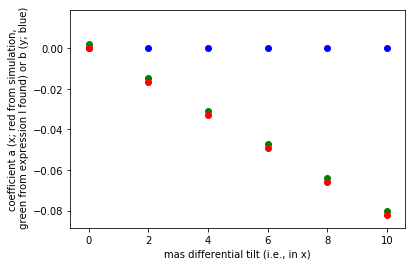

In [41]:
plt.scatter(mas_steps,df["phase_normVec_highFreqPerfect_R_y"], color='b')
plt.scatter(mas_steps,np.add(predicted_alpha,0.002), color='g')
#plt.scatter(mas_steps,df["phase_normVec_lowFreqPerfect_y"], color='g')
plt.scatter(mas_steps,df["phase_normVec_highFreqPerfect_R_x"], color='r')
#plt.scatter(df["framenum"],df["ampl_med_rect"], color='k')
plt.xlabel("mas differential tilt (i.e., in x)")
plt.ylabel("coefficient a (x; red from simulation,\n green from expression I found) or b (y; blue)")
#plt.show()
#plt.savefig("coefficients_from_tilt_Neq2048.png")

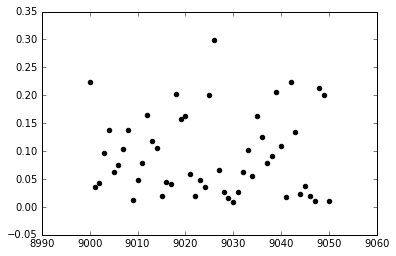

In [32]:
#plt.scatter(df["framenum"],df["phase_normVec_highFreqPerfect_L_x"], color='b')
#plt.scatter(df["framenum"],df["phase_normVec_highFreqPerfect_L_y"], color='r')
plt.scatter(df["framenum"],np.sqrt(np.power(df["phase_normVec_highFreqPerfect_L_x"].values,2.),
                                   np.power(df["phase_normVec_highFreqPerfect_L_y"].values,2.)), color='k')
plt.show()

In [31]:
df["phase_normVec_highFreqPerfect_L_x"].values

array([-0.22388664,  0.03532201,  0.04263646,  0.09670333,  0.13806682,
        0.06264305,  0.07437832,  0.10406917,  0.13770817,  0.0130518 ,
        0.04849938,  0.07805505,  0.16507925, -0.11828314,  0.10587168,
        0.01997622,  0.04414176,  0.04174093,  0.20225613,  0.1573356 ,
        0.16340876, -0.05937441,  0.01921177,  0.04834072,  0.03569861,
        0.20098138,  0.29882959, -0.06531678,  0.02702249, -0.01544348,
       -0.00905657, -0.02664275,  0.06245704,  0.10148444,  0.05575474,
        0.16293086,  0.1253292 ,  0.07855067,  0.09040437,  0.20554595,
        0.10896996,  0.01830214,  0.22330628,  0.13376922, -0.02249788,
        0.03710376,  0.01961676,  0.01056479,  0.21352153,  0.20020515,
       -0.01058913])

In [ ]:
# read in PSF analysis file and make plots

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
psf_analysis = pd.read_csv("psf_analysis_altair_data.csv", na_values="--")

In [36]:
[print(i) for i in psf_analysis.keys()]

framenum
amp_med_highFreqPerfect_L
amp_med_highFreqPerfect_R
amp_med_lowFreqPerfect
amp_med_rect
amp_normVec_highFreqPerfect_L_x
amp_normVec_highFreqPerfect_L_y
amp_normVec_highFreqPerfect_R_x
amp_normVec_highFreqPerfect_R_y
amp_normVec_lowFreqPerfect_x
amp_normVec_lowFreqPerfect_y
amp_normVec_rect_x
amp_normVec_rect_y
arg_med_highFreqPerfect_L
arg_med_highFreqPerfect_R
arg_med_lowFreqPerfect
arg_med_rect
arg_normVec_highFreqPerfect_L_x
arg_normVec_highFreqPerfect_L_y
arg_normVec_highFreqPerfect_R_x
arg_normVec_highFreqPerfect_R_y
arg_normVec_lowFreqPerfect_x
arg_normVec_lowFreqPerfect_y
arg_normVec_rect_x
arg_normVec_rect_y


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

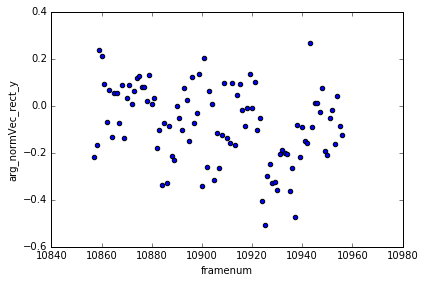

In [46]:
x_axis = "framenum"
y_axis = "arg_normVec_rect_y"
plt.scatter(psf_analysis[x_axis][6500:6600],psf_analysis[y_axis][6500:6600])
plt.xlabel(x_axis)
plt.ylabel(y_axis)
#plt.ylim([-0.00005,0.00005])
plt.tight_layout()
plt.savefig(y_axis+"_vs_"+x_axis+"_testDetail.pdf")
#plt.show()

In [ ]:
# how are FFTs affected by
# 1. fringe movement
# 2. changing visibility
# 3. stuff listed in my table

# ... and how good am I at finding the center of the PSF?

In [ ]:
# based on the images, decide whether to move HPC in piston, tip, tilt
# iterate?
# maybe I don't want to move HPC in piston, because I found the center of the envelope with the grism,
# and Phasecam isn't closed yet